Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [506]:
HYPERTRAINING = True
CV = 5
SCORING = 'explained_variance'
'neg_mean_squared_error' #  nope
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
SAVE_MODEL_NAME = 'offense_regressor'
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor_regression_metrics_no_winger"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'shooting','ShortPassing','Dribbling','BallControl',
                     'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']
PLAYER_ATTRIBUTES = [ 'Finishing',   'LongShots','ShotPower',   'Volleys',   'FKAccuracy',  'HeadingAccuracy',
                      'Positioning', 'Vision' ,'ShortPassing','LongPassing',
                     'BallControl','Dribbling', 
                      'Acceleration', 'SprintSpeed', 'Agility','Reactions', 
                      'Balance', 'Stamina','Jumping','Composure']


In [507]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [508]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [509]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [510]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [511]:
df = df[df.winger == 0]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<26]

df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
78.0    35
75.0    33
77.0    31
73.0    25
76.0    25
79.0    20
74.0    20
83.0    20
84.0    18
81.0    17
80.0    15
70.0    14
72.0    14
71.0    14
68.0    12
69.0    11
82.0    11
67.0    10
64.0     8
66.0     7
87.0     5
90.0     4
86.0     4
89.0     4
88.0     4
85.0     3
91.0     2
63.0     2
62.0     2
65.0     2
92.0     1
61.0     1
57.0     1
Name: count, dtype: int64


In [512]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
54050,W. Rooney,2011,24.0,24.0,25.0,91.0,91.0,88.0,90.0,90.0,drop,ST
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,drop,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,72.0,72.0,drop,ST
253002,G. Raspadori,2022,21.0,21.0,22.0,88.0,88.0,74.0,79.0,79.0,valid,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST


In [513]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [514]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [515]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

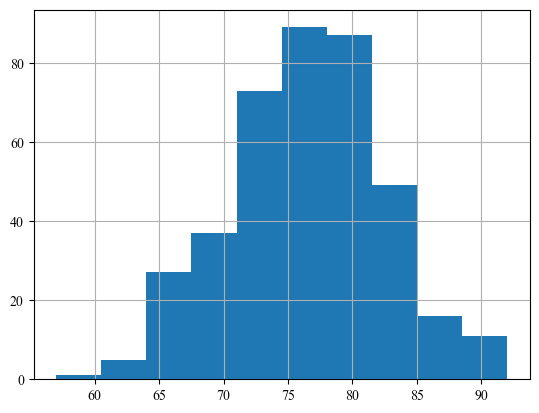

In [516]:
df['target'].hist()

In [517]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [518]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [519]:
y_train.describe()

count    191.000000
mean      76.643979
std        5.597833
min       57.000000
25%       73.000000
50%       77.000000
75%       80.000000
max       91.000000
Name: target, dtype: float64

In [520]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [521]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


[I 2023-12-01 20:06:53,868] A new study created in memory with name: no-name-0837aa79-f866-446b-b129-f0b2cd93f4e7
[I 2023-12-01 20:06:54,491] Trial 0 finished with value: -21.637120202069443 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 0.2765596520474064, 'min_samples_leaf': 0.1607988516638487, 'max_features': 0.46775465658302917}. Best is trial 0 with value: -21.637120202069443.
[I 2023-12-01 20:06:55,261] Trial 1 finished with value: -29.65397189361292 and parameters: {'n_estimators': 177, 'max_depth': 3, 'min_samples_split': 0.654313035660551, 'min_samples_leaf': 0.24430930331306172, 'max_features': 0.7803047710201771}. Best is trial 1 with value: -29.65397189361292.
[I 2023-12-01 20:06:57,765] Trial 2 finished with value: -22.991092922539 and parameters: {'n_estimators': 471, 'max_depth': 1, 'min_samples_split': 0.2867250879847905, 'min_samples_leaf': 0.23351024051723682, 'max_features': 0.537494589596963}. Best is trial 1 with value: -29.6539718936129

Best hyperparameters: {'n_estimators': 202, 'max_depth': 6, 'min_samples_split': 0.7789686972153241, 'min_samples_leaf': 0.49586183560931996, 'max_features': 0.8701937445794361}
Best Mean neg_mean_squared_error: -32.54841206923434


In [522]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


[I 2023-12-01 20:07:36,287] A new study created in memory with name: no-name-85b17e6a-f848-4bdd-8f75-116032912145
[I 2023-12-01 20:07:37,730] Trial 0 finished with value: -21.67881079066622 and parameters: {'n_estimators': 439, 'max_depth': 7, 'min_samples_split': 0.7313298587128948, 'min_samples_leaf': 0.17063509478474984, 'max_features': 0.6031090670738118}. Best is trial 0 with value: -21.67881079066622.
[I 2023-12-01 20:07:39,464] Trial 1 finished with value: -23.23251852502851 and parameters: {'n_estimators': 433, 'max_depth': 7, 'min_samples_split': 0.27786921198419623, 'min_samples_leaf': 0.31944076664526333, 'max_features': 0.970794744510221}. Best is trial 1 with value: -23.23251852502851.
[I 2023-12-01 20:07:40,660] Trial 2 finished with value: -23.68355128555006 and parameters: {'n_estimators': 374, 'max_depth': 7, 'min_samples_split': 0.4182288099921887, 'min_samples_leaf': 0.28627288090959785, 'max_features': 0.8198186767006551}. Best is trial 2 with value: -23.68355128555

Best hyperparameters: {'n_estimators': 384, 'max_depth': 4, 'min_samples_split': 0.5035759005870325, 'min_samples_leaf': 0.24085132877249046, 'max_features': 0.8822150817639923}
Best Mean neg_mean_squared_error: -24.94315561098654


In [523]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


[I 2023-12-01 20:08:17,487] A new study created in memory with name: no-name-fa944fe7-e502-4cdd-bc51-053c11b5c659
[I 2023-12-01 20:08:17,510] Trial 0 finished with value: -19.286947194363357 and parameters: {'alpha': 7.1725087468156365, 'fit_intercept': True}. Best is trial 0 with value: -19.286947194363357.
[I 2023-12-01 20:08:17,532] Trial 1 finished with value: -8211.272010667617 and parameters: {'alpha': 9.660861909654988, 'fit_intercept': False}. Best is trial 1 with value: -8211.272010667617.
[I 2023-12-01 20:08:17,551] Trial 2 finished with value: -8335.41890832777 and parameters: {'alpha': 6.811795952358737, 'fit_intercept': False}. Best is trial 2 with value: -8335.41890832777.
[I 2023-12-01 20:08:17,572] Trial 3 finished with value: -8302.722097213853 and parameters: {'alpha': 7.514680265676897, 'fit_intercept': False}. Best is trial 2 with value: -8335.41890832777.
[I 2023-12-01 20:08:17,594] Trial 4 finished with value: -19.590583440685798 and parameters: {'alpha': 3.349912

Best hyperparameters: {'alpha': 0.01870703399044782, 'fit_intercept': False}
Best Mean neg_mean_squared_error: -8760.074773630118


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


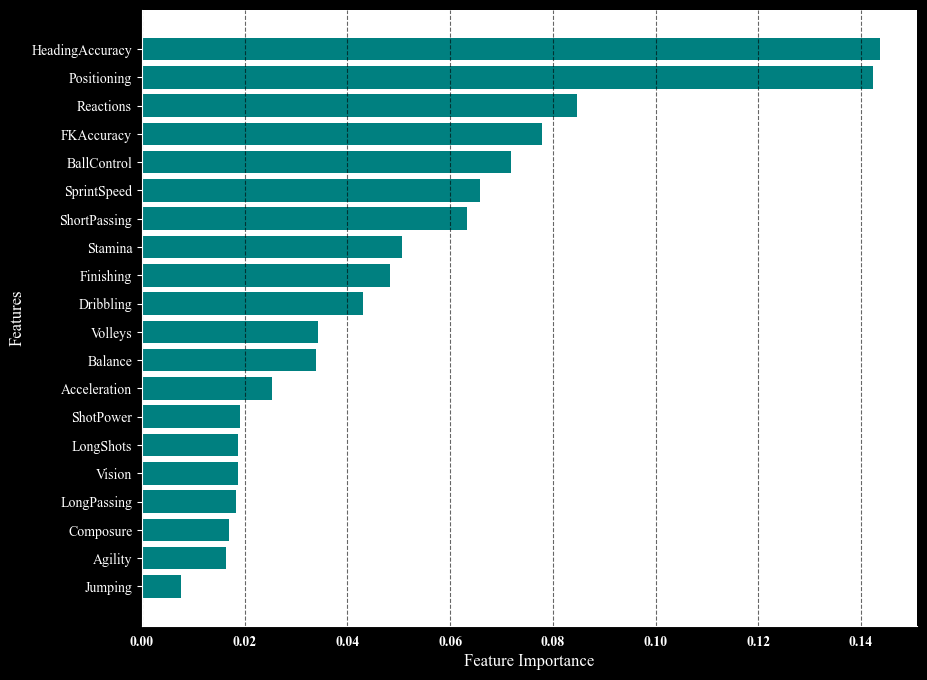

100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


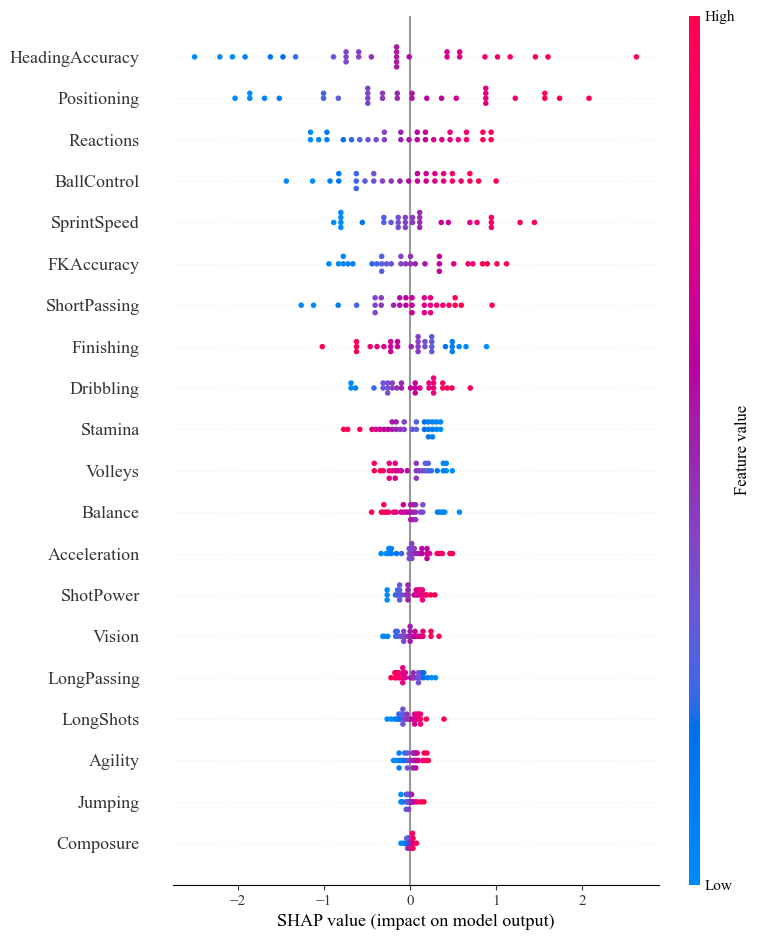

              precision    recall  f1-score   support

       False       0.91      1.00      0.95        59
        True       0.00      0.00      0.00         6

    accuracy                           0.91        65
   macro avg       0.45      0.50      0.48        65
weighted avg       0.82      0.91      0.86        65

Linear Regression training----->


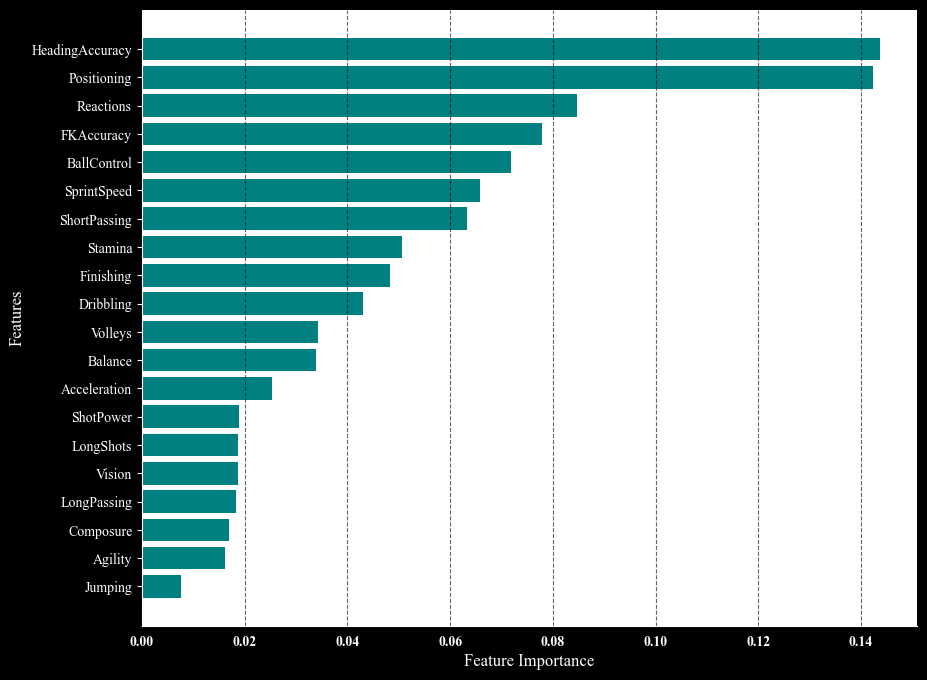

100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


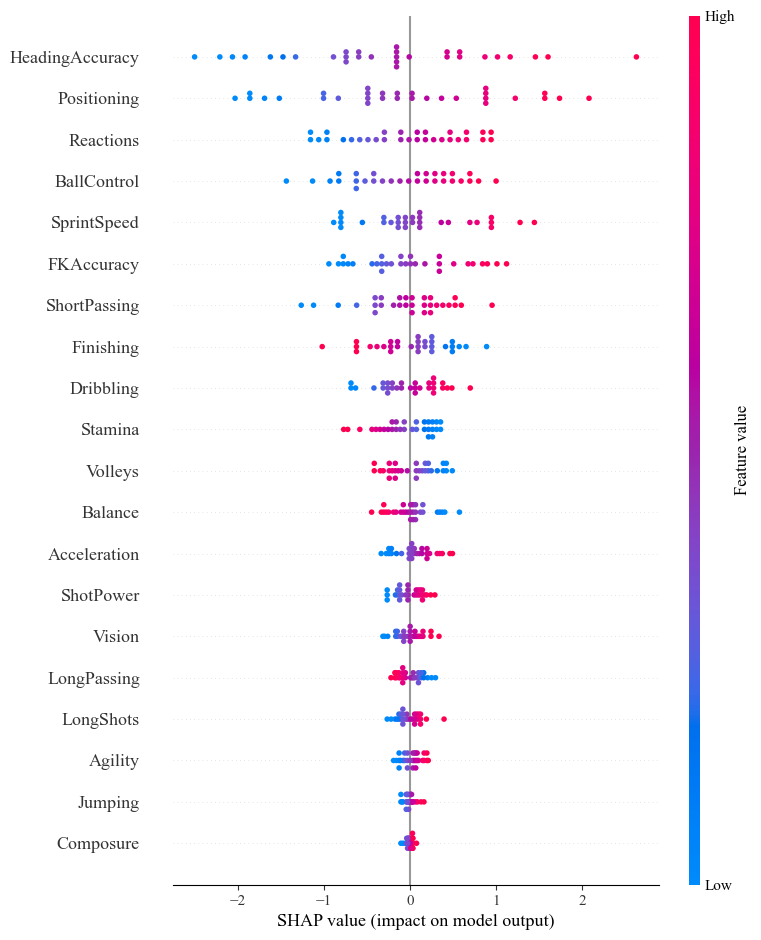

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        59
        True       0.33      0.33      0.33         6

    accuracy                           0.88        65
   macro avg       0.63      0.63      0.63        65
weighted avg       0.88      0.88      0.88        65

Random Forest Regressor training----->


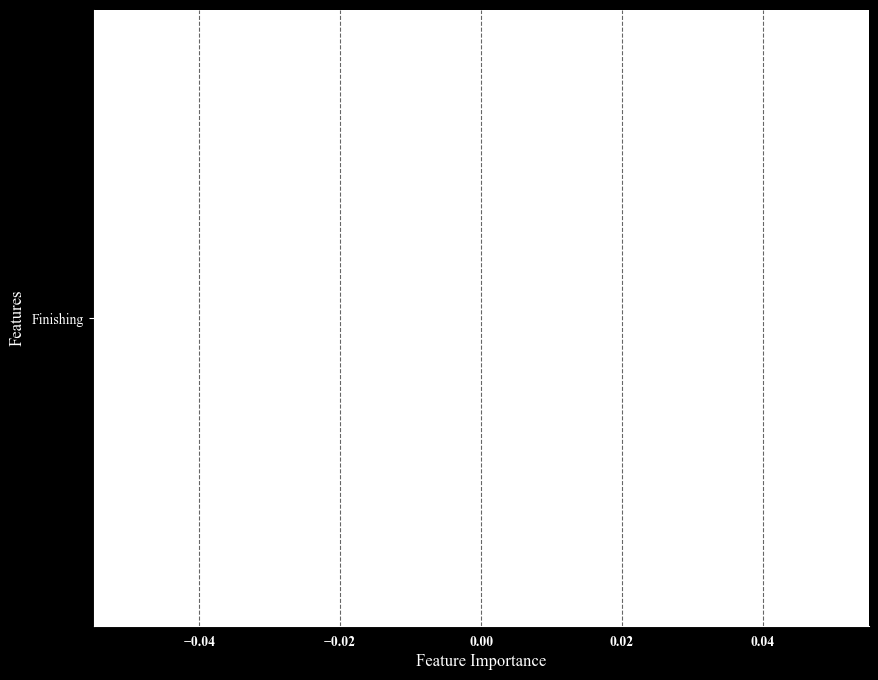

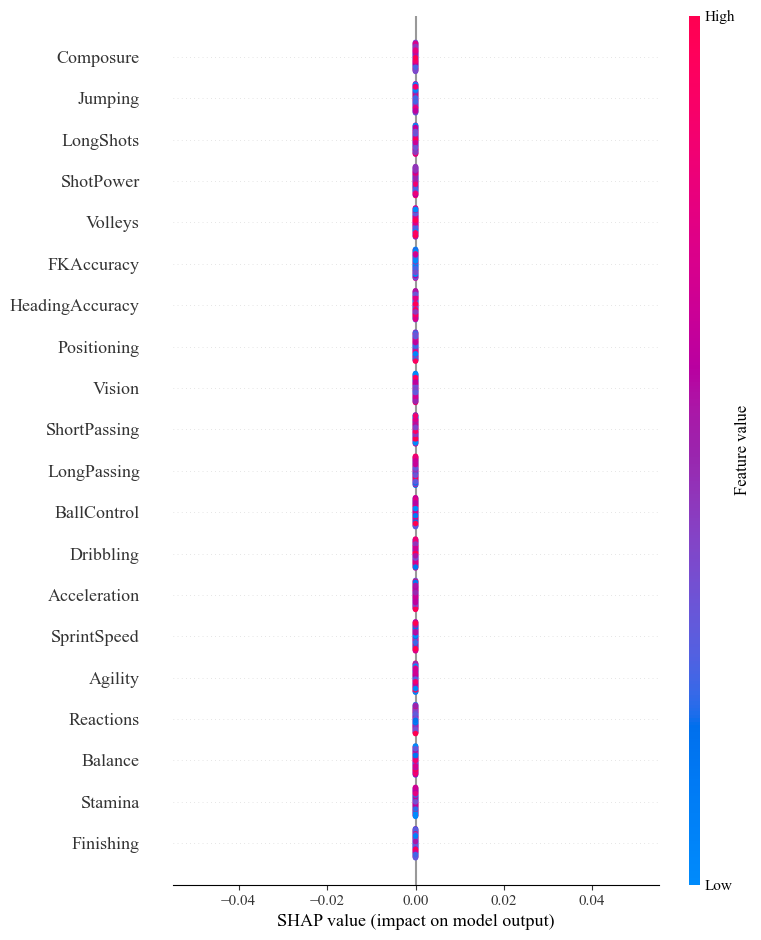

              precision    recall  f1-score   support

       False       0.91      1.00      0.95        59
        True       0.00      0.00      0.00         6

    accuracy                           0.91        65
   macro avg       0.45      0.50      0.48        65
weighted avg       0.82      0.91      0.86        65

Gradient Boosting Regressor training----->


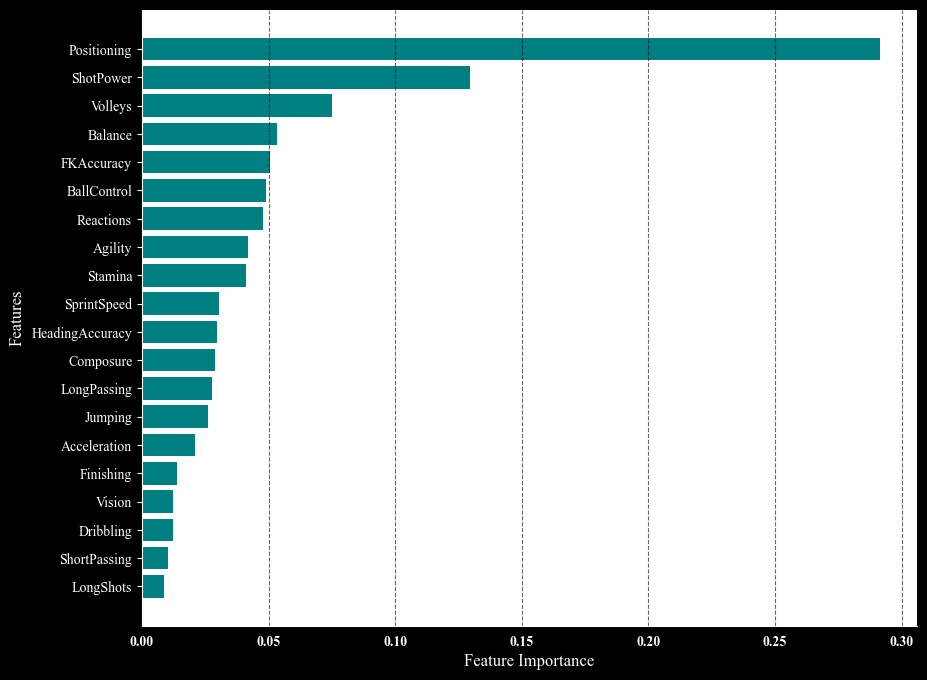

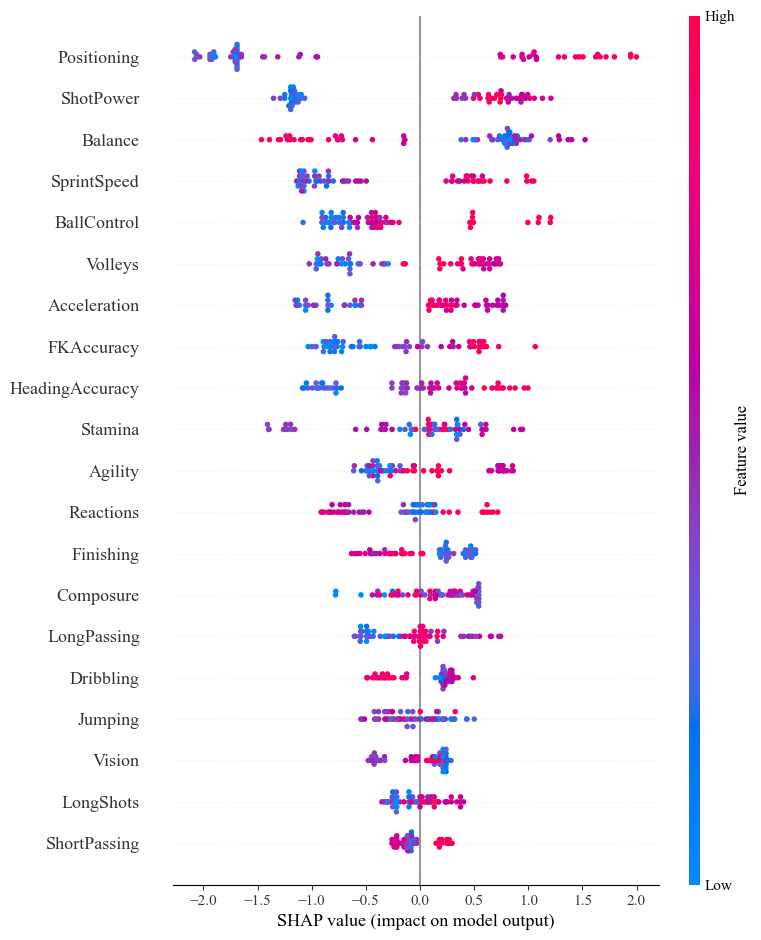

              precision    recall  f1-score   support

       False       0.95      0.92      0.93        59
        True       0.38      0.50      0.43         6

    accuracy                           0.88        65
   macro avg       0.66      0.71      0.68        65
weighted avg       0.89      0.88      0.88        65

Model: Ridge Regression
Mean Squared Error: 5637.13
Mean Absolute Error: 74.99
R2 Score: -192.07

Model: Linear Regression
Mean Squared Error: 16.17
Mean Absolute Error: 3.38
R2 Score: 0.45

Model: Random Forest Regressor
Mean Squared Error: 37.90
Mean Absolute Error: 5.18
R2 Score: -0.30

Model: Gradient Boosting Regressor
Mean Squared Error: 23.90
Mean Absolute Error: 3.96
R2 Score: 0.18



In [524]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
       
        y_pred = model.predict(X_test_scaled_df)
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df)
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df,K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [525]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [526]:
X_train.describe()

,Finishing,LongShots,ShotPower,Volleys,FKAccuracy,HeadingAccuracy,Positioning,Vision,ShortPassing,LongPassing,BallControl,Dribbling,Acceleration,SprintSpeed,Agility,Reactions,Balance,Stamina,Jumping,Composure
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,71.732984,63.047120,70.115183,62.947644,48.424084,63.884817,70.020942,59.842932,63.230366,49.643979,71.031414,70.743455,77.900524,77.973822,73.916230,67.031414,69.157068,66.340314,68.460733,28.753927
std,5.844197,7.909547,7.580955,9.437182,13.439269,9.433274,7.991415,9.660905,8.512487,11.548477,6.803951,7.757655,8.236348,7.608468,9.694453,8.553796,11.473376,10.371743,10.604233,31.439787
min,54.000000,42.000000,50.000000,35.000000,22.000000,33.000000,51.000000,34.000000,41.000000,21.000000,51.000000,47.000000,51.000000,55.000000,33.000000,45.000000,32.000000,31.000000,32.000000,0.000000
25%,68.000000,58.000000,65.000000,57.000000,38.000000,58.000000,65.000000,53.000000,57.500000,41.000000,67.000000,65.500000,73.000000,74.000000,69.000000,60.500000,63.500000,59.500000,62.500000,0.000000
50%,71.000000,63.000000,70.000000,64.000000,46.000000,64.000000,71.000000,60.000000,63.000000,49.000000,72.000000,71.000000,78.000000,78.000000,74.000000,68.000000,70.000000,67.000000,69.000000,0.000000
75%,76.000000,68.000000,76.000000,69.000000,58.000000,72.000000,76.000000,67.000000,70.000000,58.000000,75.000000,76.000000,83.000000,84.000000,80.000000,73.000000,77.000000,72.500000,75.000000,61.000000
max,86.000000,87.000000,88.000000,84.000000,77.000000,85.000000,88.000000,82.000000,83.000000,79.000000,87.000000,87.000000,94.000000,92.000000,95.000000,86.000000,94.000000,91.000000,92.000000,81.000000


In [527]:
y_test.describe()

count    65.000000
mean     73.692308
std       5.445535
min      63.000000
25%      70.000000
50%      73.000000
75%      77.000000
max      91.000000
Name: target, dtype: float64

In [528]:
my_model = regression_results['Linear Regression']['Model']


In [529]:
result_df = pd.Series(my_model.predict(X_test_scaled_df),index=X_test_scaled_df.index)
len(result_df)

65

<Axes: >

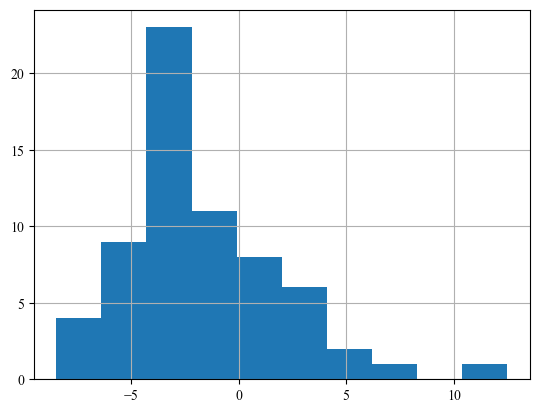

In [530]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

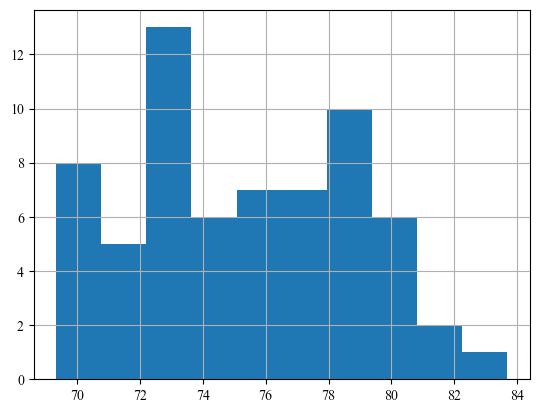

In [531]:
result_df.sort_values(ascending=False).hist()

In [532]:
(y_test-result_df).describe()

count    65.000000
mean     -1.652753
std       3.694182
min      -8.467385
25%      -3.682440
50%      -2.327574
75%       0.258869
max      12.469606
dtype: float64

In [533]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,LongShots,ShotPower,Volleys,FKAccuracy,HeadingAccuracy,Positioning,Vision,ShortPassing,LongPassing,BallControl,Dribbling,Acceleration,SprintSpeed,Agility,Reactions,Balance,Stamina,Jumping,Composure
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,
241721,Rafael Leão,2020,76.0,62.0,77.0,65.0,58.0,58.0,78.0,69.0,67.0,52.0,75.0,77.0,88.0,86.0,75.0,73.0,59.0,70.0,64.0,76.0
246191,J. Álvarez,2020,67.0,59.0,73.0,65.0,66.0,60.0,65.0,60.0,63.0,54.0,72.0,68.0,72.0,78.0,77.0,66.0,80.0,63.0,65.0,65.0
239085,E. Håland,2020,72.0,62.0,74.0,70.0,51.0,62.0,73.0,57.0,67.0,33.0,74.0,72.0,79.0,83.0,66.0,72.0,65.0,73.0,70.0,78.0
256853,M. Tillman,2021,67.0,59.0,68.0,48.0,32.0,59.0,57.0,53.0,57.0,40.0,62.0,62.0,67.0,65.0,58.0,54.0,61.0,62.0,65.0,54.0
246430,D. Vlahović,2021,74.0,64.0,78.0,68.0,37.0,68.0,74.0,54.0,60.0,40.0,72.0,70.0,57.0,66.0,55.0,68.0,48.0,56.0,64.0,66.0
238616,Pedro Neto,2020,63.0,62.0,64.0,52.0,40.0,51.0,64.0,56.0,60.0,46.0,71.0,70.0,79.0,78.0,86.0,65.0,80.0,49.0,52.0,58.0


In [534]:
y_test[outlier]

ID      Name         FIFA
241721  Rafael Leão  2020    86.0
246191  J. Álvarez   2020    80.0
239085  E. Håland    2020    91.0
256853  M. Tillman   2021    74.0
246430  D. Vlahović  2021    84.0
238616  Pedro Neto   2020    78.0
Name: target, dtype: float64

In [535]:
result_df[outlier]

ID      Name         FIFA
241721  Rafael Leão  2020    80.437251
246191  J. Álvarez   2020    76.141368
239085  E. Håland    2020    78.530394
256853  M. Tillman   2021    69.366661
246430  D. Vlahović  2021    76.431430
238616  Pedro Neto   2020    74.449066
dtype: float64

In [536]:
(y_test/result_df).describe()

count    65.000000
mean      0.977724
std       0.048798
min       0.883156
25%       0.950329
50%       0.967862
75%       1.003559
max       1.158787
dtype: float64

In [537]:
(y_test/result_df).describe()

count    65.000000
mean      0.977724
std       0.048798
min       0.883156
25%       0.950329
50%       0.967862
75%       1.003559
max       1.158787
dtype: float64

In [538]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.74002804],
       [0.74002804, 1.        ]])

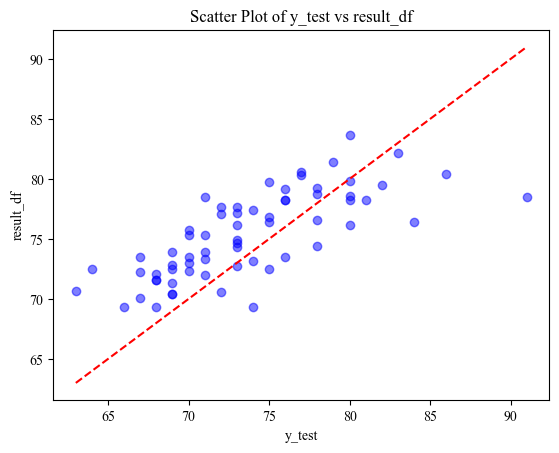

In [539]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [540]:
TARGET_OVERALL = 80

In [541]:
result_df = result_df.sort_values(ascending=False)

In [542]:
result_df.head(50)

ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.682440
210315  De Tomás          2020    82.168158
216549  A. Sørloth        2021    81.370636
235866  C. Kouamé         2020    80.558088
241721  Rafael Leão       2020    80.437251
220085  L. Waldschmidt    2020    80.303186
231447  D. Malen          2020    79.803410
225289  N. Fernández      2020    79.732943
253072  D. Núñez          2021    79.464660
251470  C. De Ketelaere   2021    79.254942
241522  J. Wind           2021    79.157113
244622  Puado             2020    78.777503
246186  Arthur Cabral     2021    78.569713
239085  E. Håland         2020    78.530394
245396  V. Supryaga       2021    78.507783
243630  J. David          2020    78.267095
221014  Carlos Fernández  2020    78.250434
251852  K. Adeyemi        2021    78.216790
245158  L. Suárez         2021    78.216716
252042  João Pedro        2021    77.648950
251756  R. Nteka          2021    77.638673
244797  P. Musa           2021    77.441653
2

In [543]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.682440
210315  De Tomás          2020    82.168158
241721  Rafael Leão       2020    80.437251
dtype: float64

In [544]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

8


ID      Name           FIFA
231447  D. Malen       2020    79.803410
253072  D. Núñez       2021    79.464660
246186  Arthur Cabral  2021    78.569713
239085  E. Håland      2020    78.530394
243630  J. David       2020    78.267095
251852  K. Adeyemi     2021    78.216790
246430  D. Vlahović    2021    76.431430
246191  J. Álvarez     2020    76.141368
dtype: float64

In [545]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

4


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.682440
216549  A. Sørloth        2021    81.370636
235866  C. Kouamé         2020    80.558088
220085  L. Waldschmidt    2020    80.303186
dtype: float64

In [546]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

51


ID      Name              FIFA
243315  Dani Gómez        2020    74.940808
246044  Andrés Martín     2020    75.299137
251105  D. Joveljić       2020    75.324638
247888  S. Esposito       2021    75.764338
233139  C. Itten          2021    76.197891
245940  S. Wamangituka    2020    76.414876
246147  M. Greenwood      2020    76.571000
246762  S. Koita          2021    76.797771
225668  K. Grant          2020    77.093895
239025  I. Niane          2020    77.133713
244797  P. Musa           2021    77.441653
251756  R. Nteka          2021    77.638673
252042  João Pedro        2021    77.648950
245158  L. Suárez         2021    78.216716
221014  Carlos Fernández  2020    78.250434
245396  V. Supryaga       2021    78.507783
244622  Puado             2020    78.777503
241522  J. Wind           2021    79.157113
251470  C. De Ketelaere   2021    79.254942
225289  N. Fernández      2020    79.732943
dtype: float64

In [547]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.75      0.56      0.64        43
        True       0.42      0.64      0.51        22

    accuracy                           0.58        65
   macro avg       0.59      0.60      0.57        65
weighted avg       0.64      0.58      0.60        65

